In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Mise en place de distances de dissimilarités
---------------
Chaque indice de dissimilarité est défini comme une fonction, prenant en argument deux séries temporelles, assimilables à des vecteurs indexés par le temps. On suppose que celles-ci sont de longueur égale, sauf s'il est spécifié autrement.

In [2]:
serie_1 = np.random.exponential(1,100)
serie_2 = np.random.exponential(10,100)

## Distances agnostiques de modèle

### Distances de Minkowski
C'est la distance la plus classique. Celle-ci calcule point à point la différence entre les séries. Celle-ci fait l'hypothèse de l'indépendance entre chaque point : elle est insensible aux permutations. Celle-ci dépend du paramètre $q$, qui permet de moduler la sensibilité de la distance aux points très éloignes : plus $q$ est élevé, plus les grandes distances seront pénalisées.

$$d_{minkowski}(X_T, Y_T) = (\sum_{t=1}^{T}|X_t - Y_t|^q)^{\frac{1}{q}} $$

In [159]:
def minkowski(X,Y,q):
    """
    Computes the Minkowski dissimilarity indice of degree q between two time series.
    
    :param X: Time serie. Numpy array.
    :param Y: Time serie. Numpy array.
    :param q: The degree. Must be an integer.
    
    :return dis: The dissimilarity indices
    
    TODO: Assert that the series have the same length
    """
    if q != round(q) or q < 1:
        print("q must be a positive integer.")
        return ValueError
    return sum(abs(X-Y) ** q)**(1/float(q))

In [4]:
minkowski(serie_1, serie_2, 2)

15273.039887420644


123.58414092196719

### La distance de Fréchet

Considérons l'ensemble des séquences préservant l'ordre des observations que nous notons $r$.

$$ r = ((X_{a_1}, Y_{b_1}), (X_{a_2}, Y_{b_2}) ... , (X_{a_m}, Y_{a_m})) $$
avec $$a_i, b_j \in {1, ..., T}$$ $$ a_1 = b_1 = 1, a_m = b_m = T $$ $$a_{i+1} \in {a_i, a_i + 1}$$ $$b_{i+1} \in {b_i, b_i +1}$$

Par exemple, pour T=3:

$$ r = ((X_1, Y_1), (X_1, Y_2), (X_2, Y_1), (X_2, Y_2), (X_2, Y_3), (X_3, Y_2), (X_3, Y_3))$$

On définit alors la distance de Fréchet comme:

$$ d_{frechet} = min_{r \in m}(max_{i =1, ..., m} |X_{a_i} - Y_{b_i}|)$$

Celle-ci prend ainsi en compte l'ordre des informations et introduit une forme de dépendance entre les observations. Elle peut être calculée sur des séries de longueur différente.

In [5]:
def frechet(X, Y):
    """
    Computes the Frechet distance between two time series.
    
    :param X: Time serie. Numpy array.
    :param Y: Time serie. Numpy array.
    
    :return dis: The distance.
    
    TODO: S'assurer que bien ça.
    TODO. Hyper optimisable.
    """
    T = len(X) - 1
    r_1 = list()
    r_2 = list()
    r_3 = list()
    for i in range(T-1):
        r_1.extend([abs(X[i] - Y[i])])
        r_2.extend([abs(X[i] - Y[i+1])])
        r_3.extend([abs(X[i +1] - Y[i])])
    max_1 = max(r_1)
    max_2 = max(r_2)
    max_3 = max(r_3)
    return min([max_1, max_2, max_3])

In [6]:
frechet(serie_1, serie_2)

46.31633054172948

### La distance DTW

Elle a un intérêt lorsqu'une série est une translation d'une autre.

In [201]:
def sinusoidal(x, lag = 0):
    return np.cos(x-lag)

In [223]:
serie_1 = sinusoidal(np.arange(0, 10, 0.1))
serie_2 = sinusoidal(np.arange(0, 10, 0.1), 1.5)

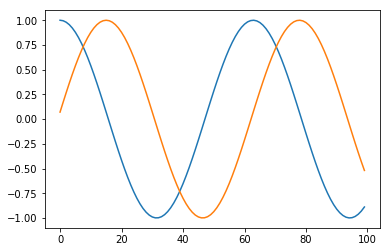

In [224]:
plt.plot(np.arange(len(serie_1)), serie_1)
plt.plot(np.arange(len(serie_2)), serie_2)

In [54]:
def dtw(X, Y, dist_fun, window_resctriction=None):
    """
    Computes the DTW distance between two time series.
    
    :param X: Time serie. Numpy array.
    :param Y: Time serie. Numpy array.
    :param dist: A function representing a distance.
    :param window_restriction: The maximum time window to work on.
    
    :return dis: The distance.
    :return path: The path with the better minimization distance
    
    TODO: Bien comprendre et commenter.
    TODO: Hyper optimisable.
    """
    # Compute the distance matrix
    # TODO: this is a similarity matrix, thus symetric -> I'm doing the computation twice.
    dist = np.zeros((len(X), len(Y)))
    for i in range(len(Y)):
        for j in range(len(X)):
            dist[i,j] = dist_fun(X[i], Y[j]) 
    
    ## Compute 
    ## The cost of the path to take
    path_cost = np.zeros((len(X), len(Y)))
    path_cost[0,0] = dist[0,0]
    
    # Working on the first row
    for i in range(1, len(X)):
        path_cost[0,i] = dist[0,i] + path_cost[0, i-1] 
    
    # Working on the first column
    for i in range(1, len(Y)):
        path_cost[i,0] = dist[i,0] + path_cost[i-1, 0]
        
    # Otherwise:
    for i in range(1, len(X)):
        for j in range(1, len(Y)):
            path_cost[i, j] = min(path_cost[i-1, j-1], path_cost[i-1, j], path_cost[i, j-1]) + dist[i, j]

    return path_cost[len(X)-1,len(Y)-1]

In [173]:
def dtw_best_path(X, Y, dist_fun, window = None):
    # Compute the distance matrix
    # TODO: this is a similarity matrix, thus symetric -> I'm doing the computation twice.
    dist = np.zeros((len(X), len(Y)))
    for i in range(len(Y)):
        for j in range(len(X)):
            dist[i,j] = dist_fun(X[i], Y[j]) 
            
    # If there is a window value, check that this window is bigger than the difference
    if window:
        window = max(window, abs(len(X) - len(Y)))
    
    ## Compute 
    ## The cost of the path to take
    path_cost = np.zeros((len(X), len(Y)))
    path_cost[0,0] = dist[0,0]
    
    # Working on the first row
    for i in range(1, len(X)):
        path_cost[0,i] = dist[0,i] + path_cost[0, i-1] 
    
    # Working on the first column
    for i in range(1, len(Y)):
        path_cost[i,0] = dist[i,0] + path_cost[i-1, 0]
        
    # Otherwise:
    for i in range(1, len(X)):
        if not window:
            for j in range(1, len(Y)):
                path_cost[i, j] = min(path_cost[i-1, j-1], path_cost[i-1, j], path_cost[i, j-1]) + dist[i, j]
        else:
            for j in range(max(1, i - window), min(len(X), i + window)):
                path_cost[i, j] = min(path_cost[i-1, j-1], path_cost[i-1, j], path_cost[i, j-1]) + dist[i, j]

    # Work backwards to find better path
    path = [[len(X)-1, len(Y)-1]]
    cost = 0
    i = len(Y)-1
    j = len(X)-1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if path_cost[i-1, j] == min(path_cost[i-1, j-1], path_cost[i-1, j], path_cost[i, j-1]):
                i = i - 1
            elif path_cost[i, j-1] == min(path_cost[i-1, j-1], path_cost[i-1, j], path_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [y, x] in path:
        cost = cost + dist[x, y]
    return path, cost    

In [174]:
def dist_abs(x,y):
    return abs(x-y)

In [230]:
dtw_best_path(serie_1, serie_2, dist_abs)

([[99, 99],
  [99, 98],
  [99, 97],
  [99, 96],
  [99, 95],
  [99, 94],
  [99, 93],
  [99, 92],
  [99, 91],
  [99, 90],
  [99, 89],
  [99, 88],
  [99, 87],
  [99, 86],
  [99, 85],
  [99, 84],
  [98, 83],
  [97, 82],
  [96, 81],
  [95, 80],
  [94, 79],
  [93, 78],
  [92, 77],
  [91, 76],
  [90, 75],
  [89, 74],
  [88, 73],
  [87, 72],
  [86, 71],
  [85, 70],
  [84, 69],
  [83, 68],
  [82, 67],
  [81, 66],
  [80, 65],
  [79, 64],
  [78, 63],
  [77, 62],
  [76, 61],
  [75, 60],
  [74, 59],
  [73, 58],
  [72, 57],
  [71, 56],
  [70, 55],
  [69, 54],
  [68, 53],
  [67, 52],
  [66, 51],
  [65, 50],
  [64, 49],
  [63, 48],
  [62, 47],
  [61, 46],
  [60, 45],
  [59, 44],
  [58, 43],
  [57, 42],
  [56, 41],
  [55, 40],
  [54, 39],
  [53, 38],
  [52, 37],
  [51, 36],
  [50, 35],
  [49, 34],
  [48, 33],
  [47, 32],
  [46, 31],
  [45, 30],
  [44, 29],
  [43, 28],
  [42, 27],
  [41, 26],
  [40, 25],
  [39, 24],
  [38, 23],
  [37, 22],
  [36, 21],
  [35, 20],
  [34, 19],
  [33, 18],
  [32, 17],
  [3

In [225]:
plt.plot(serie_1, 'bo-' ,label='x')
plt.plot(serie_2, 'g^-', label = 'y')
plt.legend();
paths = dtw_best_path(serie_1, serie_2, dist_abs)[0]
for [map_x, map_y] in paths:
    plt.plot([map_x, map_y], [serie_1[map_x], serie_2[map_y]], 'r')

La taille de la fenêtre importe aussi : elle met une limite sur les points avec lesquels les distances sont calculées. On considère ainsi qu'une fois un certain intervalle dépassé, il ne s'agit plus d'un "stretch" mais d'une vraie différence entre les séries.
Dans notre exemple, on a un décalage de 20 entre chaque phase. On voit que pour une fenêtre inférieure à cet intervalle, le chemin (et donc le coût) pour atteindre le chemin est plus élevé, mais une fois cette fenêtre dépassée, on retrouve la même valeur qu'en l'absence de décalage.

In [236]:
dtw_best_path(serie_1, serie_2, dist_abs, 1)[1]

150.46756610110518

In [240]:
dtw_best_path(serie_1, serie_2, dist_abs, 50)[1]

11.575981275016044

### Use Case: DTW vs Minkowski
-------------
La différence entre DTW est qu'elle prend en compte "le décalage" temporel entre deux séries, ce qui n'est pas le cas pour Minkowski, qui ne prend en compte qu'un décalage en valeur. Mais aucune distance n'est "meilleure" que l'autre, tout dépend du résultat que l'on souhaite obtenir.

Comparons ainsi le comportement de ces distances sur différents individus, en utilisant DTW (avec distance de Minkowski d'ordre 1) et la distance de Minkowski d'ordre 1 point à point.

In [244]:
serie_1 = sinusoidal(np.arange(0, 10, 0.1))
serie_2 = sinusoidal(np.arange(0, 10, 0.1), 1.5)
serie_3 = serie_1 + 0.5

In [245]:
plt.plot(serie_1, 'bo-' , label = "base")
plt.plot(serie_2, 'g^-', label = "translation temporelle")
plt.plot(serie_3, 'r^-', label = "translation amplitude")

plt.legend()

In [246]:
print("Serie 1-2, DTW : {}".format(dtw_best_path(serie_1, serie_2, dist_abs)[1]))
print("Serie 2-3, DTW : {}".format(dtw_best_path(serie_2, serie_3, dist_abs)[1]))
print("Serie 1-3, DTW : {}".format(dtw_best_path(serie_1, serie_3, dist_abs)[1]))

Serie 1-2, DTW : 11.575981275
Serie 2-3, DTW : 26.2976840194
Serie 1-3, DTW : 22.1719982395


On voit que pour la distance DTW, la série représentant la translation temporelle est de loin la plus proche, par rapport à celle translatée en amplitude.

In [247]:
print("Serie 1-2, Minkowski : {}".format(minkowski(serie_1, serie_2, 1)))
print("Serie 2-3, Minkowski : {}".format(minkowski(serie_2, serie_3, 1)))
print("Serie 1-3, Minkowski : {}".format(minkowski(serie_1, serie_3, 1)))

Serie 1-2, Minkowski : 85.5966550542
Serie 2-3, Minkowski : 80.8216252928
Serie 1-3, Minkowski : 50.0


On voit que pour la distance de Minkowski, c'est la translation en amplitude qui est le plus proche de la courbe originale.

### Proximité et corrélation temporelle
--------------
Alhame Douzal (yay) proposé une mesure de dissimilarité qui prend à la fois en compte la proximité des observations et la corrélation temporelle entre les séries, et donc leur comportement global.

La corrélation temporelle des observations est définie par :

$$ CORT(X_T, Y_T) = \frac{\sum_{t=1}^{T-1} (X_{t+1} - X_t) (Y_{t+1} - Y_t)}{(\sum_{t=1}^{T-1} (X_{t+1} - X_t))^{1/2} (\sum_{t=1}^{T-1}(Y_{t+1} - Y_t)^2)^{1/2}} $$

Celle-ci vaut 1 si jamais le comportement instantanné est linéairement le même et -1 s'il est exactement contraire. Pour une valeur de 0, l'évolution est **linéairement** indépendante.

In [248]:
def corr_temp(X, Y):
    """
    Computes temporal correlation between two series.
    
    :param X: A time serie. Numpy array.
    :param Y: A time serie. Numpy array.
    
    :result corr: The correlation coefficient.
    """
    cov = 0
    sd_x = 0
    sd_y = 0
    for i in range(len(X) - 2):
        cov = cov + (X[i+1] - X[i]) * (Y[i+1] - Y[i])
        sd_x = sd_x + (X[i+1] - X[i]) ** 2
        sd_y = sd_y + (Y[i+1] - Y[i]) ** 2
    return cov/(math.sqrt(sd_x) * math.sqrt(sd_y))

Pour illustrer nos propos, considérons une série, sa translation temporelle et sa translation en amplitude (en opposition de phase, retard de $\frac{\pi}{2}$).

In [257]:
serie_1 = sinusoidal(np.arange(0, 10, 0.1))
serie_2 = sinusoidal(np.arange(0, 10, 0.1), math.pi / 2)
serie_3 = serie_1 + 0.5

In [258]:
plt.plot(serie_1, 'bo-' , label = "base")
plt.plot(serie_3, 'g^-', label = "translation amplitude")
plt.plot(serie_2, 'r^-', label = "translation temporelle")

In [259]:
print("Serie 1-2, Corr temp : {}".format(corr_temp(serie_1, serie_2)))
print("Serie 2-3, Corr temp : {}".format(corr_temp(serie_2, serie_3)))
print("Serie 1-3, Corr temp : {}".format(corr_temp(serie_1, serie_3)))

Serie 1-2, Corr temp : -0.0137360039259
Serie 2-3, Corr temp : -0.0137360039259
Serie 1-3, Corr temp : 1.0


On remarque ainsi que :
- Pour la différence en amplitude, le coefficient de corrélation temporelle est exactement de 1 : les séries ont les mêmes variations aux mêmes instants.
- Pour la translation temporelle, le coefficient de corrélation temporelle est (presque) nul : les variations des sérieus sont indépdendantes aux mêmes instants.

Douzal propose alors de normaliser ce coefficient de corrélation par les valeurs prises par la série, pour ainsi prendre en compte les différences d'amplitude entre les courbes. Ainsi, ce coefficient ce définit par :
$$ d_{CORT}(X_T, Y_T) = \phi_k(CORT(X_T, Y_T)) \times d(X_T, Y_T)$$

avec $\phi_k$ une fonction permettant de moduler l'influence du facteur de corrélation. Douzal propose ainsi : $$ \phi_k = \frac{2}{(1 + exp(k \times u))}$$ (le paramètre k restant à fixer).

In [261]:
def phi(u, k):
    """
    Temporal correlation coefficient modulation function.
    
    :param u: Integer on which the function is computed.
    :param k: Smoothing parameter.
    
    :return value: Value of the function.
    """
    return 2 / (1 + math.exp(k * u))

In [263]:
def douzal_index(X, Y, dist, k):
    """
    Computes the douzal similarity index between two series.
    
    :param X: Time serie. Numpy array.
    :param Y: Time serie. Numpy array.
    :param dist: 
    :param k: Tuning parameter for the tuning function
    
    :return value: Value for the index
    """
    cor = corr_temp(X, Y)
    return 